# CRF

模型参考https://github.com/bojone/crf/

CRF实现参考https://github.com/bojone/crf/blob/master/crf_keras.py#L54

#### util

In [2]:
#export
import sys
if __name__ == '__main__': sys.path.append('..')
import exp.common as common
from exp.common import tqdm

In [2]:
import gc
def print_gc(file=sys.stdout):
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
                print(type(obj), obj.size(), file=file)
        except: pass

In [3]:
from pprint import pprint
def pj(*args, **kargs):
    if common.IN_JUPYTER:
        pprint(*args, **kargs)

In [4]:
#export
import operator
import numpy as np

In [5]:
#test_export
def is_cuda():
    return torch.cuda.is_available()

In [6]:
import matplotlib.pyplot as plt
def pxy(x, y, name='idk', plt=plt, ):
    name = str(name)
    fig, = plt.plot(x,y, )
    fig.set_label(name)
    plt.legend()

#### READ Data

In [7]:
#test_export
import pandas as pd
def read_data(Forever=False, status='train'):
    sent, tags = [],[]
    con = True
    while con:
        with open(f'../data/CRF/ResumeNER/{status}.char.bmes', 'r', encoding='UTF-8') as f:
            for line in f.readlines():
                line = line.strip()
                if not line:
                    yield sent, tags
                    sent, tags = [],[]
                    continue

                assert len(line.split())>=2, line
                w, tag = line.split()
                sent.append(w)
                tags.append(tag)
        con = Forever

from torch.utils.data import DataLoader
# next(read_data())

In [8]:
#test_export
for data in read_data(status='test'):
    break
# data

In [9]:
#test_export
for data in read_data():
    break
# data

In [10]:
d = {1:3}
# d.items()
dict(map(reversed, d.items()))

{3: 1}

In [11]:
#test_export
import sure
from collections import Counter

# 准备数据
# Counter return 0 for unknow key
class C2ID(Counter):
    
    # 0 for unknow
    def __init__(self):
        super().__init__(self)
        self.min_freq = 1
        # 0 for unknow
        self.indexer = 0
        self.freq_cnt = Counter()
        self._reverse_dict = {}
    
    def touchc(self, c):
        self.freq_cnt[c] += 1
        
    def touchs(self, s):
        for c in s:
            self.touchc(c)
    
    def update_index(self):
        for k,v in self.freq_cnt.items():
            if v < self.min_freq: continue
            if k in self: continue
                
            self._reverse_dict[self.indexer]=k
            self[k] = self.indexer
            
            self.indexer += 1
    
    def reverse(self, idx):
        return self._reverse_dict[idx]
    
    def reveres_list(self, list_idx):
        return list(map(self.reverse, list_idx))
            
c2id = C2ID()
tag2id = C2ID()
# tag2id.indexer = 0
UNK = 'UNK'
PAD = 'PAD'
for cv in [c2id, tag2id]:
    cv.touchs([UNK, PAD])

for sent, tags in read_data():
    c2id.touchs(sent)
    tag2id.touchs(tags)

In [12]:
len(c2id.freq_cnt)

1794

In [13]:
#test_export
# token 的分布

def is_breaker(c,t):
    if c2id[c] == 0:
        if t[0] == 'B':return True
        if t[0] == 'M':return True
        if t[0] == 'S':return True
    return False

def check_breaker():
    max_len = 0
    breaker_c = []
    for sent, tags in read_data():
        max_len = max(len(sent), max_len)
        for c, t in zip(sent, tags):
            if is_breaker(c, t): breaker_c.append(c)
    return max_len, breaker_c

# sorted(c2id.freq_cnt.items(), key=operator.itemgetter(1))[:30]
df = pd.DataFrame(c2id.freq_cnt.items())
mxlen, breaker_c = check_breaker()

# 先不考虑去除低频项
c2id.update_index() # 0 for padding
tag2id.update_index() # 0 for unknown char
print('mxlen', mxlen, len(breaker_c))
import pandas  as pd
# df = df.sort_values(by=1)

# df.describe()
# c2id.min_freq = 2
# c2id.update_index()
# 检查有没有打断标签


mxlen 178 65671


In [14]:
#test_export
# token 的分布
import pandas  as pd
sorted(c2id.freq_cnt.items(), key=operator.itemgetter(1))[:30]
df = pd.DataFrame(c2id.freq_cnt.items())
df = df.sort_values(by=1)
df.describe()

,1
count,1794.000000
mean,69.175585
std,280.915003
min,1.000000
25%,2.000000
50%,6.000000
75%,23.000000
max,5141.000000


In [15]:
#test_export
# tag 的分布
import pandas  as pd
sorted(tag2id.freq_cnt.items(), key=operator.itemgetter(1))[:30]
df = pd.DataFrame(tag2id.freq_cnt.items())
# df = df.sort_values(by=1)
# df.describe()
df[ list(map(lambda x:x[0] == 'B' or x[0] == 'S', df[0]) )][1].sum()
# df
tag2id.reveres_list([1,2,3])

['PAD', 'B-NAME', 'E-NAME']

#### onehot and padding

In [16]:
#test_export
num_embeddings = len(c2id)
num_label = len(tag2id)

In [17]:
#export
def padding(padding_idx,X):
    X = list(X)
    max_len = max(map(len, X))
    for i,x in enumerate(X):
        X[i] = x + [padding_idx] * (max_len - len(x))
    return X

In [18]:
#export
import torch
from torch import nn
def onehot(y, dim_size):
    """
    y: shape (batch_size, max_seq_len)
    """
    assert len(y.shape) == 2, y.shape
    eye = np.eye(dim_size)
    return eye[y]

In [19]:
#test_export
import numpy as np
from functools import partial
from pprint import pprint
from tqdm import tqdm
import math
assert isinstance( math.ceil(0.3), int)

class get_data():
    def __init__(self, batch_size = 2, status='train'):
        self.batch_size = batch_size
#         self.len = math.ceil( len(list(read_data()))/batch_size )
        self.status = status
        self.len = len(list(read_data(status=self.status)))//batch_size 
        
    def __iter__(self):
        batch_size = self.batch_size
        cnt = 0
        X = []
        Y = []
        def set_train():
            a = padding(c2id[PAD]  , X)
            b = padding(tag2id[PAD], Y)
            return tuple(map( np.array, (a,b)))
        
        for x, y in read_data(status=self.status):
            cnt += 1
            X.append(list(map(  c2id.__getitem__, x)))
            Y.append(list(map(tag2id.__getitem__, y)))
    
            if cnt == batch_size:
                yield set_train()
                
                # clean up
                cnt = 0
                X = []
                Y = []
        
        return set_train()
    
    def __len__(self):
        return self.len

In [20]:
#test_export
for train in common.tqdm(get_data()):
    pass
print(list(map(np.shape, train)),  len(get_data()) )

def parse_train(train):
    train_X, train_Y = train
    train_Y = onehot(train_Y, num_label)
    train_Y = torch.Tensor(train_Y)
    train_X = torch.LongTensor(train_X)
    return train_X, train_Y 
list(map(lambda x:x.shape, parse_train(train)))

/home/zengjianjun/anaconda3/envs/py3torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.



[(2, 22), (2, 22)] 1910


[torch.Size([2, 22]), torch.Size([2, 22, 30])]

In [21]:
#test_export
for train in common.tqdm(get_data(status='test')):
    pass
print(list(map(np.shape, train)))
print(list(map(lambda x:x.shape, parse_train(train))),  len(get_data(status='test')) )
del train

/home/zengjianjun/anaconda3/envs/py3torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.



[(2, 74), (2, 74)]
[torch.Size([2, 74]), torch.Size([2, 74, 30])] 238


In [22]:
#test_export
onehot(np.array(
    [
        [1,2,3],
        [0,3,1]
    ]
), 4)

array([[[0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]],

       [[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]]])

### CRF

#### TopK

In [23]:
#export
import sure
from queue import PriorityQueue
class TopK:
    def __init__(self, k, topks = None):
        # (priority_number, data)
#         pq = PriorityQueue(k)
        assert k == 1, "not implemented"
    
        self.m_inf = -float('inf')
        self.data = None
        self.score = self.m_inf
        
        if topks is not None:
            assert len(topks) >= k
            for t in topks:
                self.put( t.get_max_data(), t.get_max_score(),)
            return 
    
#         for i in range(k):
#             pq.put_nowait((m_inf))
#         self.pq = pq
        
    def put(self,  data, score,):
        assert len(data) >= 1
        if self.score is self.m_inf:
            pass
        else :
            assert type(score) == type(self.score), "score type muse consit"
        if score > self.score:
            self.score, self.data = score, data
    
    def __str__(self):
        return (self.score, self.data).__str__()
    
    def get_max_score(self):
        return self.score
    
    def get_max_data(self):
        return self.data
    
    def get_kth_data(self, k):
        raise NotImplementedError
        
    def get_kth_score(self, k):
        raise NotImplementedError
        
    def __repr__(self):
        return self.__str__()
        
    
    
topk = TopK(1)
for i in range(10):
    topk.put( [i],i+10,)
#     print(topk.data)
# assert topk.
topk.get_max_data().should.eql([9])
topk.get_max_score().should.eql(19)

True

In [24]:
#test_export
topk = TopK(1)
topk.put( [1], 1,)
for i in range(1, 10):
    t = list(range(i)) + topk.get_max_data()
    topk.put(t, i)
topk.m_inf.should.eql(topk.m_inf)

True

#### viterbi

In [4]:
#export
def j_viterbi(logits, transitions):
    """
    Uses viterbi algorithm to find most likely tags for the given inputs.
    If constraints are applied, disallows all other transitions.
    Returns a tensor with the same size as the mask (not list)
    """
    logits = model.nodes
    mask = None
    transitions = model.crf.trans
    batch_size, sequence_length, num_tags = logits.size()

    if mask is None:
        mask = torch.ones(*logits.shape[:2], dtype=torch.bool, device=logits.device)

    # Augment transitions matrix with start and end transitions
    start_tag = num_tags
    end_tag = num_tags + 1

    # Apply transition constraints
    # inverse mask because torch.masked_fill will fill value when mask is True
    constrained_transitions = transitions.detach()
    # transitions[:num_tags, :num_tags] = constrained_transitions

    history = []
    # Transpose batch size and sequence dimensions
    mask = mask.transpose(0, 1).bool()
    logits = logits.transpose(0, 1)

    score = logits[0]

    # For each i we compute logits for the transitions from timestep i-1 to timestep i.
    # We do so in a (batch_size, num_tags, num_tags) tensor where the axes are
    # (instance, current_tag, next_tag)
    for i in range(1, sequence_length):
        # The emit scores are for time i ("next_tag") so we broadcast along the current_tag axis.
        emit_scores = logits[i].view(batch_size, 1, num_tags)
        broadcast_score = score.view(batch_size, num_tags, 1)
        inner = broadcast_score + emit_scores + constrained_transitions
        update_score, indices = inner.max(dim=1)
        # if mask[i] is True(mask[i] == 1 means this char is not padded) we use new_score,
        # otherwise last score.
        score = torch.where(mask[i].unsqueeze(1), update_score, score)
        history.append(indices)
    last_indices = score.argmax(-1)
    best_path = [last_indices]
    indices = last_indices
    # backtrace the path inversely
    for i in range(-1, -sequence_length, -1):
        recur_indices = history[i].gather(1, indices.view(batch_size, 1)).squeeze()
        indices = torch.where(mask[i], recur_indices, indices)
        best_path.insert(0, indices)
    best_path = torch.stack(best_path).transpose(0, 1)
    return best_path 

In [26]:
#export
# dont use this
def viterbi(nodes,trans_p, initial_state = None, topk = 1, start_p = None):
    """
    nodes: array, [{"<TAG>": <float>}]
    trans_p: dict, {"<TAG_A>": {"TAG_B": <float>}}, TAG_A -> TAG-B
    return_max=True: bool, set to False if your want to avoid ill endding tag and find your own.
    initial_state=None: None or list to avoid impossible starting tags
    start_p: P(o1), may be nessary
    all float number in log form
    """
    assert len(nodes.shape) == 2,len(nodes.shape)  # max_seq_len, label_num
    kth = 1
    if initial_state is None:
        initial_state = nodes[0]
        nodes = nodes[1:]
        
    def init_tok():return TopK(kth)
    
    def init_toks(): return [init_tok() for i in range(nodes.shape[-1])]

    last_best_nodes = init_toks()
    next_best_nodes = init_toks()
    
    
    for idx, (tk,score) in enumerate( zip(last_best_nodes , initial_state)):
        tk.put([idx], score)

    for node in nodes:
        for t,v in enumerate(node):

            current_best_node = init_tok() # for t
            
            for topk in last_best_nodes:
                path = topk.get_max_data()
                score = topk.get_max_score()
                
                last_t = path[-1]
                new_path = path + [t]
                tran = trans_p[last_t][t]
                
                current_best_node.put(new_path, score + tran + v)

            next_best_nodes[t] = current_best_node
            
        next_best_nodes, last_best_nodes =  last_best_nodes, next_best_nodes,
        
    topk = TopK(1, last_best_nodes)
    
    return topk.get_max_data()

In [27]:
#test_export
nodes = [
    [1, 2, 1],
    [1, 1, 3],
    [4, 1, 3],
]
trans = [
    [1, 1, 1],
    [1, 1, 1],
    [1, 1, 1],
]
nodes, trans = map(np.array, [nodes, trans])
viterbi(nodes, trans).should.eql([1,2,0])

True

#### get_shift_mask

In [28]:
#export
def get_shift_mask(labels):
    """
    labels: (batch_size, max_seq_len, num_label) in onehot all element should be 1/0
    turn num_labels into matrix of (num_label, num_label) where m[ y[i] ][ y[i+1] ] = 1, 0 for else
    return (batch_size, max_seq_len, num_label, num_label)
    """
    labels1 = labels[:, :-1, ] # y[i]

    labels2 = labels[:, 1:] # y[i + 1]

    labels1 = labels1[:, :, :, None] # as 系数, row indexer
    labels2 = labels2[:, :, None, :] # as row, col indexer

    shift_mask = labels1 * labels2
    return shift_mask

In [29]:
#test_export
import sure
tmp_num_label = 5
tmp_labels_raw = [[1,2,3,4], [3,3,3,2]]
tmp_labels = np.array(tmp_labels_raw)
tmp_labels = onehot(tmp_labels, tmp_num_label)
shift_mask = get_shift_mask(tmp_labels)

# for batch
for tags, mask in zip(tmp_labels_raw, shift_mask):
    
    # for seq
    # len = max_seq_len - 1
    for y_i, y_j,matrix in zip(tags[:-1], tags[1:], mask):
        # y_j  = y[i+1]
        matrix = np.copy(matrix)
        matrix[y_i][y_j] -= 1 # only matrix[y_i][y_j] = 1, else 0
        matrix.sum().should.eql(0)
        

#### CRF

In [30]:
#export
import math
# 👴的CRF
class CRF(nn.Module):
    def __init__(self, num_label):
        super().__init__()
        # 先不考虑padding标签的问题
        # 先不考虑mask的问题
        self.trans = nn.Parameter(torch.Tensor(num_label, num_label))
        nn.init.kaiming_uniform_(self.trans, a=math.sqrt(5))
        
    def _path_score(self, inputs, labels):
        return _path_score(inputs, labels, self.trans)
        
    def _sum_over_path_score(self, inputs, labels):
        return _sum_over_path_score(inputs, labels, self.trans)
    
    def veterbi_decode(self, nodes):
        return _veterbi_decode(nodes, self.trans.detached().numpy())
    
    def forward(self, inputs, labels):
        """
        inputs: (batch_size, max_seq_len, label_num) embed with latent dim label_nun
        labels: (batch_size, max_seq_len, label_num) ground-truth label in onehot
        return: score
       """
        path_score = self._path_score(inputs, labels)
        sum_over_path = self._sum_over_path_score(inputs, labels)
        
        return torch.sum(- path_score + sum_over_path)

In [31]:
#export
# trans[i][j]表示从i标签转移至j标签
def _path_score(inputs, labels, trans):
    """
    score of h(y[i]) ground-truch y[i] plus its g[y[i]][y[i+1]], inputs for h, trans for g
    inputs.size() # batch_size, max_seq_len, num_label
    trans.size() # num_label, num_label
    labels.size() #batch_size, max_seq_len, num_label
    """
    sum_h_score = inputs * labels # batch_size, max_seq_len, num_label
    sum_h_score = sum_h_score.sum(-1, ) # batch_size, max_seq_len
    sum_h_score = sum_h_score.sum(-1, keepdim = True) # batch_size, 1

    mask = get_shift_mask(labels) # (batch_size, max_seq_len, num_label, num_label)
    sum_g_score = mask * trans[None, None]
    sum_g_score = sum_g_score.sum((-1, -2)) # batch_size, max_seq_len
    sum_g_score = sum_g_score.sum((-1), keepdim = True) # batch_size, 1 
    path_score = sum_g_score + sum_h_score
    path_score.shape # batc_size, 1
    return path_score

def _sum_over_path_score(inputs, labels, trans):
    """
    @see https://kexue.fm/archives/5542#%E5%BD%92%E4%B8%80%E5%8C%96%E5%9B%A0%E5%AD%90
    """
    trans = trans[None, :, :] # (1, num_label, num_label,)
    Z = inputs[:,0,:]
    inputs = inputs[:, 1:,:]
    times_seq_len = inputs.shape[1]
    Z.shape
    for time_idx in range(times_seq_len):
            h = inputs[:, time_idx, :] # batch_size, num_label
            Z = Z[:,:, None] # as row coeffiecient, (batch_size, num_label, 1)
            Z = Z + trans
            Z = torch.logsumexp(Z, -2)
            Z = Z + h
    Z = torch.logsumexp(Z, -1)
    return Z

#### test CRF

##### define model

In [32]:
#test_export
import torch.functional as F
# 空也放进去映射了，不用加1，否则回出现随机的tag2id.reserve，键值不存在错误。
embedding_dim = 64
lstm_dim = 32
len(tag2id)

30

In [33]:
#test_export
# 不过crf的，用交叉熵
class TestNER(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=lstm_dim)
        self.fc = nn.Linear(lstm_dim, num_label)
        self.crf = CRF(num_label)
        self.nodes = None
        
    def decode(self):
        self.crf.veterbi_decode(self.nodes.detach.numpy())
        
    def forward_nodes(self, inputs):
        x = self.emb(inputs)
        x, (hn, cn)= self.lstm(x)
        x = self.fc(x)
        self.nodes = x
        return x
        
        
    def forward(self, inputs, labels):
        x = self.forward_nodes(inputs)
        x = self.crf(x, labels)
        return x

In [34]:
#test_export
from torch import optim
from exp.common import tqdm
for train in get_data(10):
    break;
train_X, train_Y = parse_train(train)
# differs for tensor and model
lr = 1e-2
testner= TestNER()
model = testner
del testner
op = optim.Adam(model.parameters(), lr=lr)

for ep_idx, ep in tqdm(enumerate(range(100))):
    model.zero_grad()
    loss = model(train_X, train_Y)
    loss.backward()
    if(ep_idx%10 == 0):
        print(loss)
    op.step()
    

/home/zengjianjun/anaconda3/envs/py3torch/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


tensor(23904.2969, grad_fn=<SumBackward0>)
tensor(9059.3867, grad_fn=<SumBackward0>)
tensor(4823.8872, grad_fn=<SumBackward0>)
tensor(2739.9365, grad_fn=<SumBackward0>)
tensor(1535.3125, grad_fn=<SumBackward0>)
tensor(841.6074, grad_fn=<SumBackward0>)
tensor(466.9702, grad_fn=<SumBackward0>)
tensor(286.4877, grad_fn=<SumBackward0>)
tensor(197.8009, grad_fn=<SumBackward0>)
tensor(150.2832, grad_fn=<SumBackward0>)



In [107]:
#test_exprt
my_best_path = list(common.tqdm(map(lambda nodes:viterbi(nodes, model.crf.trans), model.nodes)))
# 速度提升很大，从28.7s -> 54ms， 提升3个数量级
my_best_path =  np.array(my_best_path)
my_best_path = torch.tensor(my_best_path, dtype=torch.int64)
assert torch.allclose(j_viterbi(model.nodes, model.crf.trans), my_best_path )

/home/zengjianjun/anaconda3/envs/py3torch/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [35]:
#test_export
from seqeval.metrics import classification_report, accuracy_score

class Parser:
    def __init__(self, model):
        self.model = model
        self.in_place_nodes = False
        
    def parse_one_seq(self,seq_nodes, trans = None):
        if trans is None:
            trans = self.model.crf.trans.cpu().detach().numpy()
        pred=viterbi(seq_nodes, trans)
        return pred
    
    def parse_nodes(self, nodes=None, trans=None):
        if nodes is None:
            nodes = self.model.nodes.cpu().detach()
        if trans is None:
            trans = self.model.crf.trans.cpu().detach()
        
#         parse = partial(self.parse_one_seq, trans = trans)
#         self.y_pred = list(common.tqdm(map(parse, nodes)))
        self.y_pred = j_viterbi(nodes, trans)
        return self.y_pred
    
    def parse_test_y_pred(self, test_X, test_Y):
        assert len(test_Y.shape) == 2, "please give test_Y in shape (batch_size, max_seq_len) tag in sparse int, given"+str(test_Y.shape)
        if self.in_place_nodes:
            nodes = None
        else :
            with torch.no_grad():
                nodes = self.model.forward_nodes(test_X)
        y_pred = self.parse_nodes(nodes)
        return y_pred, test_Y
    
    def parse_test_cls_report(self, test_X, test_Y):
        """
        one in all
        """
        y_pred, y_true = self.parse_test_y_pred(test_X, test_Y)
#         y_pred = self.parse_nodes()
#         y_true = test_Y
        y_pred, y_true = map(self.cvt, (y_pred, y_true)) 
        return classification_report(y_true, y_pred)
    
    def parse_test_acc(self, test_X, test_Y):
        y_pred, y_true = self.parse_test_y_pred(test_X, test_Y)
        y_pred, y_true = map(self.cvt, (y_pred, y_true)) 
        return accuracy_score(y_true, y_pred)
    
    def cvt(self, y):
        if isinstance(y, torch.Tensor) :y = y.cpu().numpy()
        return list(map(tag2id.reveres_list, y))
    

In [36]:
#test_export
parser = Parser(model)
y_pred = parser.parse_nodes()
y_pred = parser.cvt(y_pred)
y_true = parser.cvt(train[1])
report = classification_report(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)
acc.should.eql(1.0, 0.05)

True

In [37]:
#test_export
# 应该是上一个的两倍时间
parser.in_place_nodes = True
assert report == parser.parse_test_cls_report(train_X, train[1])
parser.parse_test_acc(train_X, train[1]).should.eql(1.0)

True

In [38]:
#test_export
#应该是上一个的10倍时间
parser.in_place_nodes = False
assert report == parser.parse_test_cls_report(train_X, train[1])
parser.parse_test_acc(train_X, train[1]).should.eql(1.0)
print('all should be one', report, sep='\n')
                      
assert isinstance(y_pred, list)

all should be one
           precision    recall  f1-score   support

    TITLE       1.00      1.00      1.00        20
     CONT       1.00      1.00      1.00         2
      PAD       1.00      1.00      1.00         9
      ORG       1.00      1.00      1.00        11
     NAME       1.00      1.00      1.00         2
      PRO       1.00      1.00      1.00         2
     RACE       1.00      1.00      1.00         1
      EDU       1.00      1.00      1.00         3

micro avg       1.00      1.00      1.00        50
macro avg       1.00      1.00      1.00        50



In [39]:
#test_export
del train, train_X, train_Y,  y_pred, y_true, report
del model

##### test train

In [40]:
#test_export
class Metric():
    def __init__(self, status, parser):
        self.status = status
        self.parse = parser
        
    def cal_metric(self,  fn):
        parser, = self.parse,
        all_y_pred, all_y_true = [], []
        for test in get_data(100, status=self.status):
            test_X, _ = parse_train(test)
            if is_cuda():test_X = test_X.cuda()
            y_pred, y_true = parser.parse_test_y_pred(test_X, test[1])
            y_pred, y_true = map(parser.cvt, (y_pred, y_true)) 
            all_y_pred += y_pred
            all_y_true += y_true
        return fn(all_y_true, all_y_pred)

    def cal_acc(self):
        return self.cal_metric(accuracy_score)
        
    def cal_report(self):
        return self.cal_metric(classification_report)


In [41]:
#test_export
from io import StringIO
from exp.common import tqdm
import gc
strinfos = []
lr = 1e-1
test_ner = TestNER()
# if is_cuda():
#     test_ner.cuda()
model = test_ner 
del test_ner 
op = optim.Adam(model.parameters(), lr=lr)

In [42]:
#test_export
from torch import optim
from exp.common import tqdm
for train in get_data():
    break;
train_X, train_Y = parse_train(train)
# differs for tensor and model
lr = 1e-2
parser = Parser(model)
op = optim.Adam(model.parameters(), lr=lr)

if is_cuda():
    model.cuda()
    train_X, train_Y = map(lambda x:x.cuda(), (train_X, train_Y ) )

In [43]:
#test_export
dev_metric = Metric('dev',  parser )
for ep_idx, ep in tqdm(enumerate(range(20))):
    model.zero_grad()
    loss = model(train_X, train_Y)
    loss.backward()
    if(ep_idx%10 == 0):
        print(loss.item(), dev_metric.cal_acc())
    op.step()
    

/home/zengjianjun/anaconda3/envs/py3torch/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


915.7990112304688 0.021538461538461538
347.790283203125 0.8401465201465201



In [44]:
#test_export 
def train_ep(TEST=False, show_bar=True):
    cnt = 0
    it = get_data(100)
    it = common.tqdm(it) if show_bar else it
    losses = np.zeros(shape=(len(it), 1))
    for train in it:
        op.zero_grad()
        train_X, train_Y = parse_train(train)
        if is_cuda():
            train_X = train_X.cuda()
            train_Y = train_Y.cuda()

        loss = model(train_X, train_Y)
    #     print(outputs.shape, train_Y.shape)
    #     loss = nn.CrossEntropyLoss(outputs, train_Y)
        loss.backward()
        op.step()
#         strinfos.append(StringIO(f"{cnt}"))
        gc.collect()
        loss = loss.cpu().detach().numpy()
        if common.IN_JUPYTER or common.IN_TRAVIS: 
            if is_cuda():
                pass
            else :
                print(loss)
                if cnt > 1: break
                
            if TEST and cnt > 5: break
            
        losses.append(loss)
        cnt += 1
#         break
    return range(cnt), np.array(losses)
tp = train_ep(True)
loss = tp[1].mean()
acc = dev_metric.cal_acc()
loss, acc

/home/zengjianjun/anaconda3/envs/py3torch/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


(91355.53125, 0.9039010989010989)

In [45]:
#test_export
epo_losses = []
epo_acces = []

In [46]:
#test_export
for ep in common.tqdm(range(5)):
    if not is_cuda():
        if ep == 1:
            break
    tp = train_ep(show_bar=False)
    loss = tp[1].mean()
    acc = dev_metric.cal_acc()
    print(loss, acc)
    epo_losses.append(loss)
    epo_acces.append(acc)

/home/zengjianjun/anaconda3/envs/py3torch/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



239193.8791118421 0.9652380952380952
109475.85022615132 0.975989010989011
72219.89658717105 0.9801098901098901
53786.02559621711 0.9821611721611722
42533.36554276316 0.9823260073260073



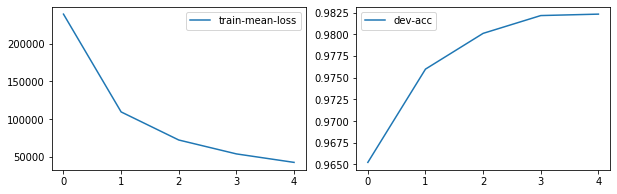

In [47]:
fig, m_axs = plt.subplots(1, 2, figsize = (10, 3)) 
pxy(range(len(epo_losses)), epo_losses, 'train-mean-loss', plt=m_axs[0])
pxy(range(len(epo_acces)), epo_acces, 'dev-acc', plt=m_axs[1])

In [48]:
#test_export
test_metric = Metric('test', parser)
test_acc = test_metric.cal_acc()
dev_metric.cal_acc().should_not.equal(test_acc, 1e-5)

True

In [49]:
#test_export
print(dev_metric.cal_report())

           precision    recall  f1-score   support

      PAD       1.00      1.00      1.00       396
      ORG       0.75      0.80      0.77       468
    TITLE       0.83      0.85      0.84       603
      PRO       0.69      0.60      0.64        15
     NAME       0.86      0.88      0.87        89
      EDU       0.87      0.91      0.89        91
     CONT       0.97      0.97      0.97        30
     RACE       0.92      1.00      0.96        11
      LOC       0.00      0.00      0.00         2

micro avg       0.85      0.88      0.86      1705
macro avg       0.85      0.88      0.86      1705



In [51]:
#test_export

In [ ]:
# print(strinfos[169].getvalue())

In [ ]:
# print_gc()

# export

In [ ]:
common.save_and_export_notebook('CRF')

<IPython.core.display.Javascript object>

Converted CRF.ipynb to ..\exp\CRF.py
Converted CRF.ipynb to ..\test\test_CRF.py
